# 网络中的网络（NiN）
:label:`sec_nin`

LeNet、AlexNet 和 VGG 都有一个共同的设计模式：通过一系列的卷积层与汇聚层来提取空间结构特征；然后通过全连接层对特征的表征进行处理。
AlexNet 和 VGG 对 LeNet 的改进主要在于如何扩大和加深这两个模块。
或者，可以想象在这个过程的早期使用全连接层。
然而，如果使用稠密层了，可能会完全放弃表征的空间结构。
*网络中的网络* (*NiN*) 提供了一个非常简单的解决方案：在每个像素的通道上分别使用多层感知机 :cite:`Lin.Chen.Yan.2013`

## (**NiN块**)

回想一下，卷积层的输入和输出由四维张量组成，张量的每个轴分别对应样本、通道、高度和宽度。
另外，全连接层的输入和输出通常是分别对应于样本和特征的二维张量。
NiN 的想法是在每个像素位置（针对每个高度和宽度）应用一个全连接层。
如果我们将权重连接到每个空间位置，我们可以将其视为 $1\times 1$ 卷积层（如 :numref:`sec_channels` 中所述），或作为在每个像素位置上独立作用的全连接层。
从另一个角度看，即将空间维度中的每个像素视为单个样本，将通道维度视为不同特征（feature）。

:numref:`fig_nin` 说明了 VGG 和 NiN 及它们的块之间主要结构差异。
NiN 块以一个普通卷积层开始，后面是两个 $1\times 1$ 的卷积层。这两个$1\times 1$ 卷积层充当带有 ReLU 激活函数的逐像素全连接层。
第一层的卷积窗口形状通常由用户设置。
随后的卷积窗口形状固定为 $1 \times 1$。

![对比 VGG 和 NiN 及它们的块之间主要结构差异。](../img/nin.svg)
:width:`600px`
:label:`fig_nin`


In [1]:
import torch
from torch import nn
from d2l import torch as d2l


def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(),
        #nn.Conv2d(out_channels, out_channels, kernel_size=3,  padding=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU())

## [**NiN模型**]

最初的 NiN 网络是在 AlexNet 后不久提出的，显然从中得到了一些启示。
NiN使用窗口形状为 $11\times 11$、$5\times 5$ 和 $3\times 3$的卷积层，输出通道数量与 AlexNet 中的相同。
每个 NiN 块后有一个最大汇聚层，池化窗口形状为 $3\times 3$，步幅为 2。

NiN 和 AlexNet 之间的一个显著区别是 NiN 完全取消了全连接层。
相反，NiN 使用一个 NiN块，其输出通道数等于标签类别的数量。最后放一个 *全局平均汇聚层*（global average pooling layer），生成一个多元逻辑向量（logits）。NiN 设计的一个优点是，它显著减少了模型所需参数的数量。然而，在实践中，这种设计有时会增加训练模型的时间。


In [4]:
net = nn.Sequential(
    nin_block(1, 12, kernel_size=3, strides=1, padding=0), #26*26
    nn.MaxPool2d(3, stride=2), #12*12
    nin_block(12, 32, kernel_size=3, strides=1, padding=1), #12*12
    nn.MaxPool2d(3, stride=2), #5*5
    # 标签类别数是10
    nin_block(32, 16, kernel_size=3, strides=1, padding=1), #5*5
    nn.AdaptiveAvgPool2d((1, 1)), # 全局平均池化 1*1
    # 将四维的输出转成二维的输出，其形状为(批量大小, 10)
    nn.Flatten(),
    nn.Linear(16, 10))

我们创建一个数据样本来[**查看每个块的输出形状**]。


In [6]:
X = torch.rand(size=(1, 1, 28, 28))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 12, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 12, 12, 12])
Sequential output shape:	 torch.Size([1, 32, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 32, 5, 5])
Sequential output shape:	 torch.Size([1, 16, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 16, 1, 1])
Flatten output shape:	 torch.Size([1, 16])
Linear output shape:	 torch.Size([1, 10])


## [**训练模型**]

和以前一样，我们使用 Fashion-MNIST 来训练模型。训练 NiN 与训练 AlexNet、VGG时相似。


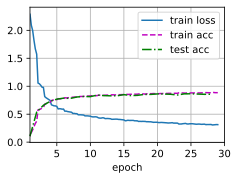

In [ ]:
lr, num_epochs, batch_size = 0.1, 30, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [5]:
torch.set_printoptions(sci_mode=False, threshold=2000000, precision=0, edgeitems=None, linewidth=None)
f = open('./nin_28*28_bigger_liner.txt', 'w', encoding='utf-8')
print(net)
f.write(str(net))
f.write('\n')
for layer in net:
    #print(layer)
    f.write(str(layer))
    f.write('\n')
    if layer.__class__.__name__ in ("Linear") :
        #print(layer.weight.data * 1024  ,'\n', layer.bias * 1024)
        f.write(str(layer.weight.data * 1024))
        f.write('\n')
        f.write(str(layer.bias * 1024))
        f.write('\n')
    elif layer.__class__.__name__ in ("Sequential") :
        for hidden_layer in layer:
            #print(hidden_layer)
            if hidden_layer.__class__.__name__ in ("Conv2d") :
                f.write(str(hidden_layer.weight.data * 1024))
                f.write('\n')
                f.write(str(hidden_layer.bias * 1024))
                f.write('\n')
f.close()

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(12, 12, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(12, 12, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
  )
  (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Sequential(
    (0): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Conv2d(32, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(10, 10, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
  )
  (5): AdaptiveAvgPool2d(output_size=(1, 1))
  (6

## 小结

* NiN使用由一个卷积层和多个 $1\times 1$ 卷积层组成的块。该块可以在卷积神经网络中使用，以允许更多的每像素非线性。
* NiN去除了容易造成过拟合的全连接层，将它们替换为全局平均汇聚层（即在所有位置上进行求和）。该汇聚层通道数量为所需的输出数量（例如，Fashion-MNIST的输出为10）。
* 移除全连接层可减少过拟合，同时显著减少NiN的参数。
* NiN的设计影响了许多后续卷积神经网络的设计。

## 练习

1. 调整NiN的超参数，以提高分类准确性。
1. 为什么NiN块中有两个 $1\times 1$ 卷积层？删除其中一个，然后观察和分析实验现象。
1. 计算NiN的资源使用情况。
    1. 参数的数量是多少？
    1. 计算量是多少？
    1. 训练期间需要多少显存？
    1. 预测期间需要多少显存？
1. 一次性直接将 $384 \times 5 \times 5$ 的表示缩减为 $10 \times 5 \times 5$ 的表示，会存在哪些问题？


[Discussions](https://discuss.d2l.ai/t/1869)
